In [1]:
import json
import requests
import pandas as pd
import folium 

In [4]:
class analisis:
    
    def __init__(self,giro,long,lat,mts):
        self.giro=giro
        self.long=long
        self.lat=lat
        self.mts=mts
        self.get(giro,long,lat,mts)
        
    def get(self,giro,long,lat,mts):
        response = requests.get("https://www.inegi.org.mx/app/api/denue/v1/consulta/Buscar/{}/{},{}/{}/44522d01-cae7-455b-9b53-7fc7d481cecb".format(giro,long,lat,mts))
        results = response.json()
        print(response)
        self.data = pd.DataFrame(response.json())
        self.filtros()
             
    def filtros(self):
        self.www=self.data.Estrato.value_counts()
        self.sss=self.data.Clase_actividad.value_counts()
        web=self.data[self.data['Sitio_internet'].apply(lambda x: len(x)) > 0]
        self.nombre=list(web["Nombre"])
        self.sitio=list(web["Sitio_internet"])
        self.info()

    def info(self):
        info = pd.read_csv('../info.csv')
        for e in info.select_dtypes('integer').columns:
            info[e]=pd.to_numeric(info[e], downcast='integer')
        for e in info.select_dtypes('float').columns:
            info[e]=pd.to_numeric(info[e], downcast='float')  
        info["fecha_alta"]=pd.to_datetime(info.fecha_alta)
        self.match(info)

    def match(self,info):
        empresas=self.data.Id
        d=info[info["id"].isin(empresas)]
        d.reset_index(drop=True,inplace=True)
        d["manzana"]=d.manzana.astype(int)
        d["clave"]=d["ageb"].astype(str) + "-" + d["manzana"].astype(str)
        self.ploteo(d)
        
    def ploteo(self,d):
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        llat=list(d.latitud)
        llong=list(d.longitud)
        name=list(d.nom_estab)
        mapa=folium.Map(location=[long, lat], tiles='openstreetmap', zoom_start=15,)
        for i in range(len(d)):
            folium.Marker([llat[i], llong[i]], icon=folium.Icon(color='red'),popup=name[i]).add_to(mapa)
        mapa.save("../mapas/mapa {}.html".format(giro))
        
        gk=pd.DataFrame(d.Año.value_counts())
        gk=gk.reset_index(drop=False)
        gk=gk.sort_values(by=['index'])
        gm=pd.DataFrame(d.Mes.value_counts())
        gm=gm.reset_index(drop=False)
        gm=gm.sort_values(by=['index'])

        ax=sns.barplot(x = 'index', y = 'Mes', data = gm, color = 'b')
        ax.set(xlabel='Mes de integración', ylabel='Numero de empresas')
        ax.figure.savefig('../images/Mes {}.png'.format(giro))
        plt.show()
        a2=sns.barplot(x = 'index', y = 'Año', data = gk, color = 'g')
        a2.set(xlabel='Año de integración', ylabel='Numero de empresas')
        a2.figure.savefig('../images/Año {}.png'.format(giro))
        plt.show()
        self.matchpobla(d)
        
    def matchpobla(self,d):
        poblaT = pd.read_csv('../pobclave.csv')
        p=d.clave
        self.dx=poblaT[poblaT["clave"].isin(p)]
        self.dx["POBMAS"]=self.dx.POBMAS.str.replace('*' , '0').astype(int)
        self.dx["POBFEM"]=self.dx.POBFEM.str.replace('*' , '0').astype(int)
        self.dx["PEA"]=self.dx.PEA.str.replace('*' , '0').astype(int)
        self.dx["PEA_M"]=self.dx.PEA_M.str.replace('*' , '0').astype(int)
        self.dx["PEA_F"]=self.dx.PEA_F.str.replace('*' , '0').astype(int)
        self.genepdf()
        
    def genepdf(self):
        from fpdf import FPDF
 
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", size=12)
        pdf.cell(200, 10, txt="Analisis de Supervivencia de Pymes en CDMX", ln=4, align="C")
        pdf.cell(90, 10, " ", 0, 2, 'C')   
        pdf.multi_cell(0,8,"La palabra de búsqueda es: '{}', con longitud {} y latitud {}\nEsta búsqueda extrae toda la competencia tanto indirecta como directa en un rango de {} mts.\
            \En total son {} empresas, con {} clases de actividades diferentes, de las cuales destacan ".format(giro,long,lat,mts,len(self.data),len(self.data.Clase_actividad.unique())) ,0,10)
        pdf.set_font("Arial", size=10)
        pdf.cell(200, 10, txt="Da click en botón rojo para ver mapa inteactivo", ln=4, align="C")
        pdf.image('../images/red.png'.format(giro), x=55,y=55, w=15, h=9, link = "../mapas/mapa {}.html".format(giro))
        pdf.cell(90, 3, " ", 0, 2, 'C')
        pdf.set_font("Arial", size=12)
        
        if len(self.sss) >= 5:
            pdf.multi_cell(0,10,"1. {} : {} \n2. {} : {} \n3. {} : {} \n4. {} : {} \n5. {} : {}".format(self.sss.index[0],self.sss[0],self.sss.index[1],self.sss[1],self.sss.index[2],self.sss[2],self.sss.index[3],self.sss[3],self.sss.index[4],self.sss[4]) ,1,10)
        else:
            pdf.multi_cell(0,10,"1. {} : {} \n2. {} : {}".format(self.sss.index[0],self.sss[0],self.sss.index[1],self.sss[1]) ,1,10)
        pdf.cell(90, 5, " ", 0, 2, 'C')
        def simple_table3(spacing=2,align="C"):
            data = [['Tamaño de Empresa', 'Número de empresas'],
                ['{}'.format(self.www.index[0]), '{}'.format(self.www[0])],
                ['{}'.format(self.www.index[1]), '{}'.format(self.www[1])],
                ['{}'.format(self.www.index[2]), '{}'.format(self.www[2])],
                ['{}'.format(self.www.index[3]), '{}'.format(self.www[3])],
                ['{}'.format(self.www.index[4]), '{}'.format(self.www[4])]]
            col_width = pdf.w / 2.2
            row_height = pdf.font_size
            for row in data:
                    for item in row:
                        pdf.cell(col_width, row_height*spacing,txt=item, border=1)
                    pdf.ln(row_height*spacing)
                    
        def simple_table3_5(spacing=2,align="C"):
            data = [['Tamaño de Empresa', 'Número de empresas'],
                ['{}'.format(self.www.index[0]), '{}'.format(self.www[0])],
                ['{}'.format(self.www.index[1]), '{}'.format(self.www[1])]]
            col_width = pdf.w / 2.2
            row_height = pdf.font_size
            for row in data:
                    for item in row:
                        pdf.cell(col_width, row_height*spacing,txt=item, border=1)
                    pdf.ln(row_height*spacing)
        if len(self.www) >4:
            simple_table3()
        else:
            simple_table3_5()

        pdf.cell(90, 5, " ", 0, 2, 'C')
        
        def simple_table4(spacing=2,align="C"):
            data = [['Nombre Establecimiento', 'Sitio Web'],
                ['{}'.format(self.nombre[0]), '{}'.format(self.sitio[0])],
                ['{}'.format(self.nombre[1]), '{}'.format(self.sitio[1])],
                ['{}'.format(self.nombre[2]), '{}'.format(self.sitio[2])],
                ['{}'.format(self.nombre[3]), '{}'.format(self.sitio[3])],
                ['{}'.format(self.nombre[4]), '{}'.format(self.sitio[4])]]
            col_width = pdf.w / 2.2
            row_height = pdf.font_size
            for row in data:
                    for item in row:
                        pdf.cell(col_width, row_height*spacing,txt=item, border=1)
                    pdf.ln(row_height*spacing)
        simple_table4()
    
        pdf.cell(90, 5, " ", 0, 2, 'C')
        pdf.multi_cell(0,6,"TABLAS DE INCORPORACIóN A DENUE *INEGI*\n *Por el momento solo contamos con info de Denue, el cual no muestra la fecha de fundación de las empresas esta se utilizaria para ver la demanda del \
            servicio/producto asi como hacer modelos que predigan la creación de nuevas empresas en el sector",0,3)
        pdf.image('../images/Año {}.png'.format(giro),w=120, h=70)
        pdf.image('../images/Mes {}.png'.format(giro),w=120, h=70)
        pdf.set_font("Arial", size=12)
        pdf.cell(94, 10, " ", 0, 2, 'C')   
        
        def simple_table2(spacing=1.5):
            data = [['Años', 'Prob. de Sobrevivir','Esperanza de Vida'],
                ['0', '0.672031','7.435258'],
                ['1', '0.491375','7.790058'],
                ['2', '0.429555','8.163900'],
                ['3', '0.385694','8.557950'],
                ['4', '0.351672','8.972207']]
            col_width = pdf.w / 3.4
            row_height = pdf.font_size
            for row in data:
                    for item in row:
                        pdf.cell(col_width, row_height*spacing,txt=item, border=1)
                    pdf.ln(row_height*spacing)
        simple_table2()
        pdf.cell(200, 15, txt="Población 'Atendida'", ln=4)
        
        def simple_table(spacing=2,align="C"):
            data = [['Población Total', '{}'.format(self.dx.POBTOT.sum())],
                ['Población Masculina', '{}'.format(self.dx.POBMAS.sum())],
                ['Población Femenina', '{}'.format(self.dx.POBFEM.sum())],
                ['Población Economicamente Activa', '{}'.format(self.dx.PEA.sum())],
                ['Población M. Economicamente Activa', '{}'.format(self.dx.PEA_M.sum())],
                ['Población M. Economicamente Activa', '{}'.format(self.dx.PEA_F.sum())]]
            col_width = pdf.w / 2.2
            row_height = pdf.font_size
            for row in data:
                    for item in row:
                        pdf.cell(col_width, row_height*spacing,txt=item, border=1)
                    pdf.ln(row_height*spacing)
        simple_table()

        pdf.output("../Analisis/Analisis {}.pdf".format(giro))



<Response [200]>


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


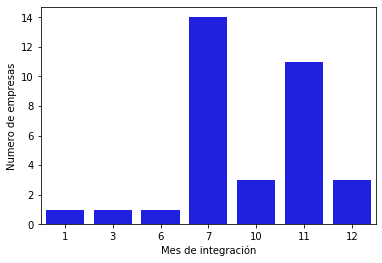

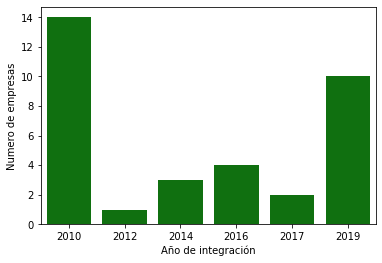

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [6]:
giro="libros"
long=19.421336 
lat=-99.162700
mts=1000
analisis(giro,long,lat,mts)